In [1]:
!git clone https://github.com/Coeze/MX4553_Modelling_Theory_Project.git

Cloning into 'MX4553_Modelling_Theory_Project'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 151 (delta 51), reused 70 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (151/151), 10.30 MiB | 21.36 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [2]:
%cd MX4553_Modelling_Theory_Project

/content/MX4553_Modelling_Theory_Project


In [3]:
!pip install fiona rasterio numpy pandas scikit-learn matplotlib matplotlib-scalebar geopandas pyproj shapely deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 9.9 MB/s eta 0:00:00


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.model import CA

In [5]:
# Load the real Pine Hollow fire data
fire = "alabama"
model = CA(grid_size=(100, 100), cell_size=1)
model.load_mtbs_fire_data(fire)
model.initialize_from_mtbs_data(fire)

Loaded burn perimeter shapefile: data/al3039808817220190514/al3039808817220190514_20190513_20190528_burn_bndy.shp
Loaded DNBR raster: data/al3039808817220190514/al3039808817220190514_20190513_20190528_dnbr.tif
Initializing from alabama fire
Loaded burn perimeter successfully
Resampling DNBR data from (299, 287) to (100, 100)
Estimated NDVI from DNBR data


True

In [6]:
#Initialise synthetic data
slope = np.random.uniform(0, 30, (100, 100))  # Slope in degrees
aspect = np.random.uniform(0, 360, (100, 100))  # Aspect in degrees
elevation = np.random.uniform(100, 1000, (100, 100))  # Elevation in meters
humidity = np.random.uniform(20, 80, (100, 100))  # Relative humidity in %
ndvi = np.random.uniform(0.1, 0.8, (100, 100))  # NDVI values

# Load the environmental data into the model
model.load_environmental_data(slope, aspect, elevation, humidity, ndvi)

model.set_environmental_data(wind_speed=5.0, wind_direction=225.0, temperature=50)


In [7]:
# Higher probability of fire with higher slope, lower humidity, and moderate NDVI
model.set_initial_fire([(50, 50)])

# Run simulation for 50 time steps
history = model.run_simulation(30)


 prob: 0.5, we: 0.17071377539976798, a_prob: 2.1842020984657072e-07, tp: 0.35, p_density: 0.6680462837105687, humidity: 11726242.625402244, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.5, we: 0.17071377539976798, a_prob: 0.0016819034150234813, tp: 0.225, p_density: 0.8356451787584169, humidity: 228.75972223310868, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.5, we: 0.17071377539976798, a_prob: 6.964227204823772e-11, tp: 0.2, p_density: 0.7110723264193565, humidity: 10631.094185557993, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.5, we: 0.17071377539976798, a_prob: 1.685733766153584e-05, tp: 0.225, p_density: 0.6827453661261398, humidity: 38260.55410698189, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.5, we: 0.17071377539976798, a_prob: 3.945895531143264e-09, tp: 0.225, p_density: 0.5596998466905061, humidity: 275431.8815174393, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.5, we: 0.17071377539976798, a_prob:

True

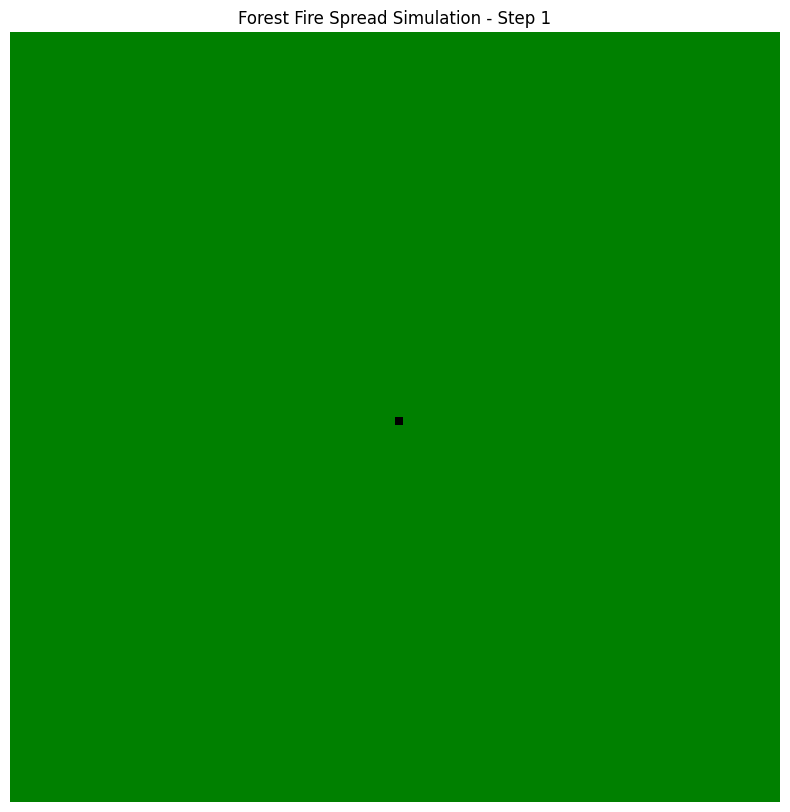

In [8]:
# Visualize the simulation
model.visualize_simulation(history)


Evaluating simulation against actual burn perimeter data:
Accuracy: 0.6354
Precision: 0.0000 (correctly predicted burned area / total predicted burned area)
Recall: 0.0000 (correctly predicted burned area / actual burned area)
F1 Score: 0.0000
Sørensen Index: 0.0000


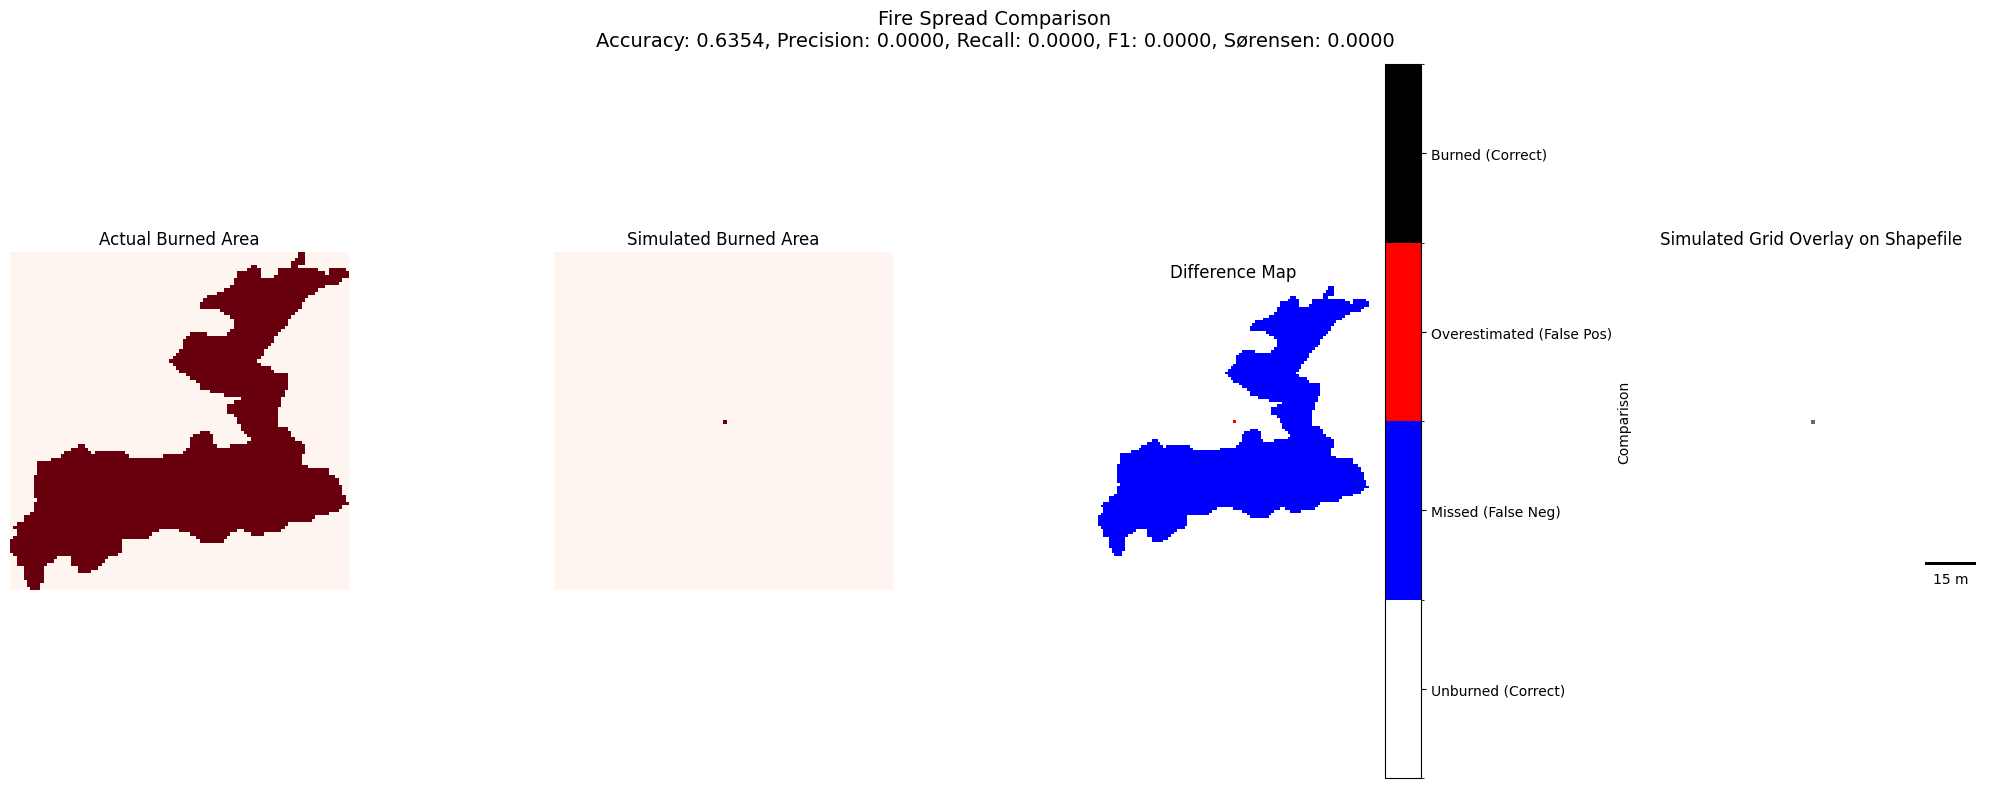

In [9]:
if model.actual_burned_area is not None:
    print("\nEvaluating simulation against actual burn perimeter data:")
    accuracy, precision, recall, sorensen = model.evaluate_simulation()
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f} (correctly predicted burned area / total predicted burned area)")
    print(f"Recall: {recall:.4f} (correctly predicted burned area / actual burned area)")
    print(f"F1 Score: {f1:.4f}")
    print(f"Sørensen Index: {sorensen:.4f}")

    # Create the comparison visualization
    fig = model.overlay_simulation_with_actual(fire)
    plt.show()

In [10]:
from src.interventions import apply_firebreak_strategy, apply_early_detection_strategy, apply_direct_attack_strategy, apply_indirect_attack_strategy, apply_combined_attack_strategy, apply_aerial_attack_strategy, apply_burnout_strategy, apply_wet_line_strategy, apply_point_protection_strategy


Evaluating strategy: No Intervention (Baseline)
Description: No firefighting intervention
Loaded burn perimeter shapefile: data/al3039808817220190514/al3039808817220190514_20190513_20190528_burn_bndy.shp
Loaded DNBR raster: data/al3039808817220190514/al3039808817220190514_20190513_20190528_dnbr.tif
 prob: 0.5, we: 0.17071377539976798, a_prob: 2.0224093504312104e-07, tp: 0.25, p_density: 0.6680462837105687, humidity: 11726242.625402244, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.5, we: 0.17071377539976798, a_prob: 0.0017162279745137567, tp: 0.25, p_density: 0.8356451787584169, humidity: 228.75972223310868, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.5, we: 0.17071377539976798, a_prob: 7.834755605426745e-11, tp: 0.35, p_density: 0.7110723264193565, humidity: 10631.094185557993, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.5, we: 0.17071377539976798, a_prob: 1.7201364960750857e-05, tp: 0.25, p_density: 0.6827453661261398, humidity: 38260

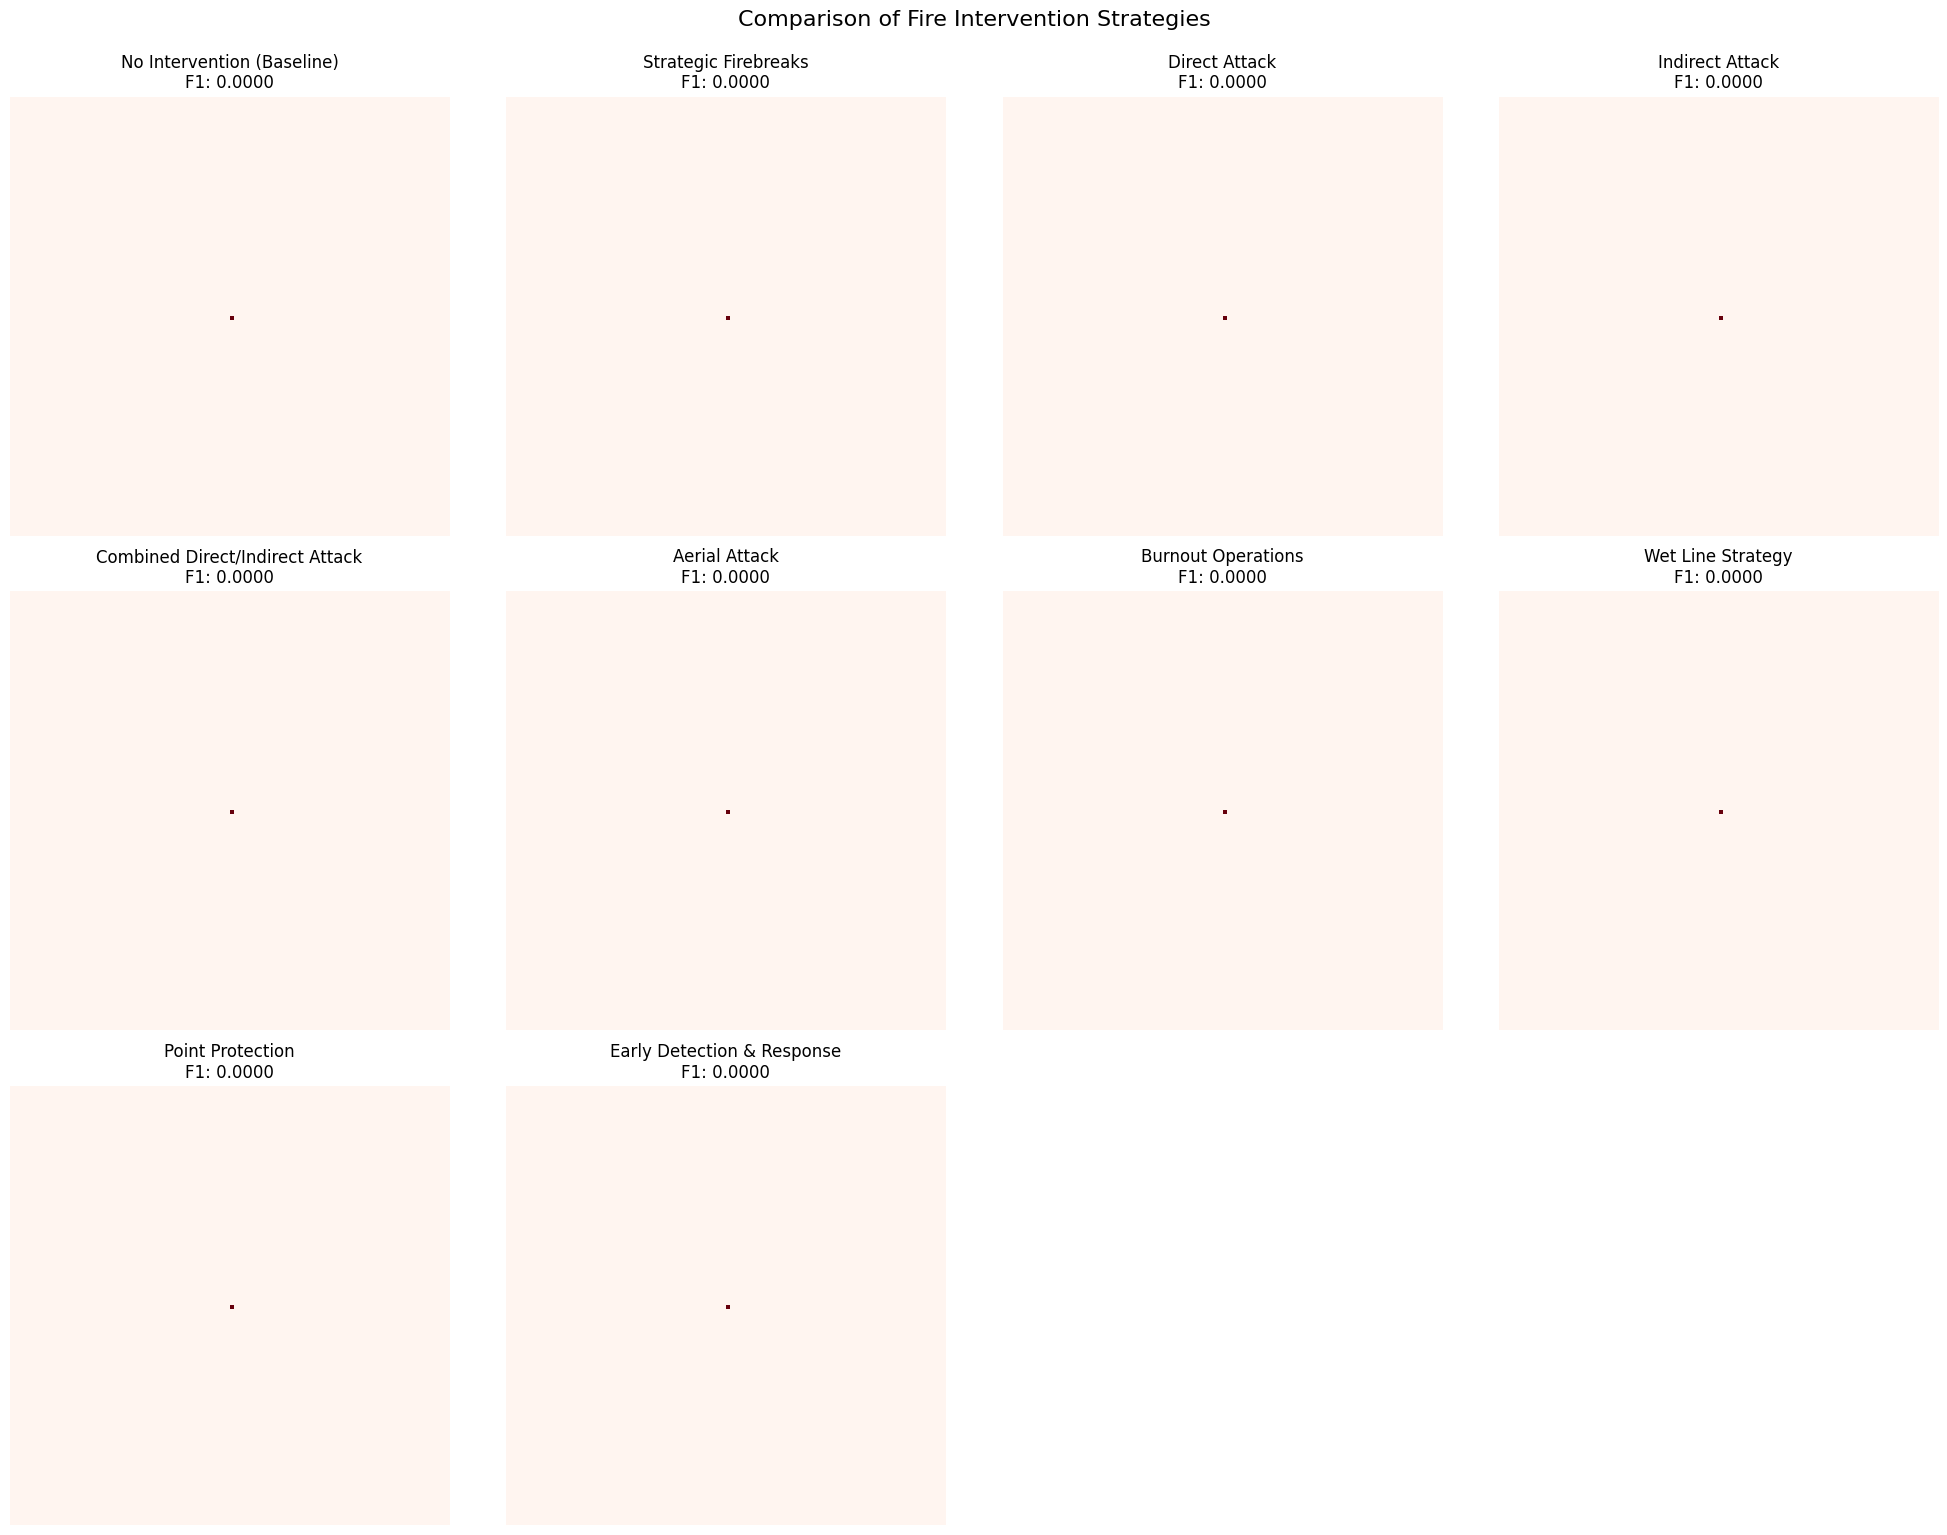

In [11]:
# Define intervention strategies
strategies = {
    'no_intervention': {
        'name': 'No Intervention (Baseline)',
        'description': 'No firefighting intervention',
        'function': lambda model, steps: model.run_simulation(steps)
    },
    'firebreaks': {
        'name': 'Strategic Firebreaks',
        'description': 'Create firebreaks to control fire spread',
        'function': apply_firebreak_strategy
    },
    'direct_attack': {
        'name': 'Direct Attack',
        'description': 'Directly attack the fire front with fire retardant',
        'function': apply_direct_attack_strategy
    },
    'indirect_attack': {
        'name': 'Indirect Attack',
        'description': 'Create control lines away from the fire edge',
        'function': apply_indirect_attack_strategy
    },
    'combined_attack': {
        'name': 'Combined Direct/Indirect Attack',
        'description': 'Combined approach with both direct and indirect methods',
        'function': apply_combined_attack_strategy
    },
    'aerial_attack': {
        'name': 'Aerial Attack',
        'description': 'Water and retardant drops from aircraft',
        'function': apply_aerial_attack_strategy
    },
    'burnout': {
        'name': 'Burnout Operations',
        'description': 'Controlled burning of fuels between control lines and fire edge',
        'function': apply_burnout_strategy
    },
    'wet_line': {
        'name': 'Wet Line Strategy',
        'description': 'Water applied to create a line of wet fuels to stop fire spread',
        'function': apply_wet_line_strategy
    },
    'point_protection': {
        'name': 'Point Protection',
        'description': 'Focus resources on protecting specific high-value points',
        'function': apply_point_protection_strategy
    },
    'early_detection': {
        'name': 'Early Detection & Response',
        'description': 'Early detection and rapid initial attack',
        'function': apply_early_detection_strategy
    }
}

# Store results for comparison
results = {}
baseline_result = None

# Create a figure for visualization of all strategies
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

# Set the initial fire locations
initial_fire = [(50, 50)]

# Run simulation for each strategy
for i, (strategy_id, strategy) in enumerate(strategies.items()):
    print(f"\nEvaluating strategy: {strategy['name']}")
    print(f"Description: {strategy['description']}")

    # Clone the base model for this strategy
    model = CA(grid_size=(100, 100), cell_size=1)
    model.load_mtbs_fire_data(fire)
    model.load_environmental_data(slope, aspect, elevation, humidity, ndvi)
    model.set_environmental_data(wind_speed=5.0, wind_direction=225.0, temperature=50)
    model.set_initial_fire(initial_fire)

    # Apply the strategy and run simulation
    history = strategy['function'](model, 30)

    # Evaluate results
    if model.actual_burned_area is not None:
        accuracy, precision, recall, sorensen = model.evaluate_simulation()
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Save metrics
        results[strategy_id] = {
            'name': strategy['name'],
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'sorensen': sorensen,
            'burned_area': np.sum(model.grid == 2),  # Count of burned cells
            'burnt_grid': (model.grid == 2).astype(int)  # Save the burnt grid for visualization
        }

        # Save baseline result for comparison
        if strategy_id == 'no_intervention':
            baseline_result = results[strategy_id]

        # Plot results
        ax = axes[i]
        ax.imshow(model.grid == 2, cmap='Reds', interpolation='none')
        ax.set_title(f"{strategy['name']}\nF1: {f1:.4f}")
        ax.axis('off')

        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  Burned Area: {results[strategy_id]['burned_area']} cells")

        # Calculate fire containment percentage if not baseline
        if baseline_result and strategy_id != 'no_intervention':
            containment = 1.0 - (results[strategy_id]['burned_area'] / baseline_result['burned_area'])
            containment_pct = max(0, containment * 100)
            results[strategy_id]['containment_pct'] = containment_pct
            print(f"  Fire Containment: {containment_pct:.1f}%")

# Fill any unused subplot spaces
for i in range(len(strategies), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle("Comparison of Fire Intervention Strategies", fontsize=16, y=1.02)
plt.show()

<ipython-input-12-718c734846f5>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(strategies, rotation=45, ha='right')
<ipython-input-12-718c734846f5>:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(strategies, rotation=45, ha='right')
<ipython-input-12-718c734846f5>:49: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


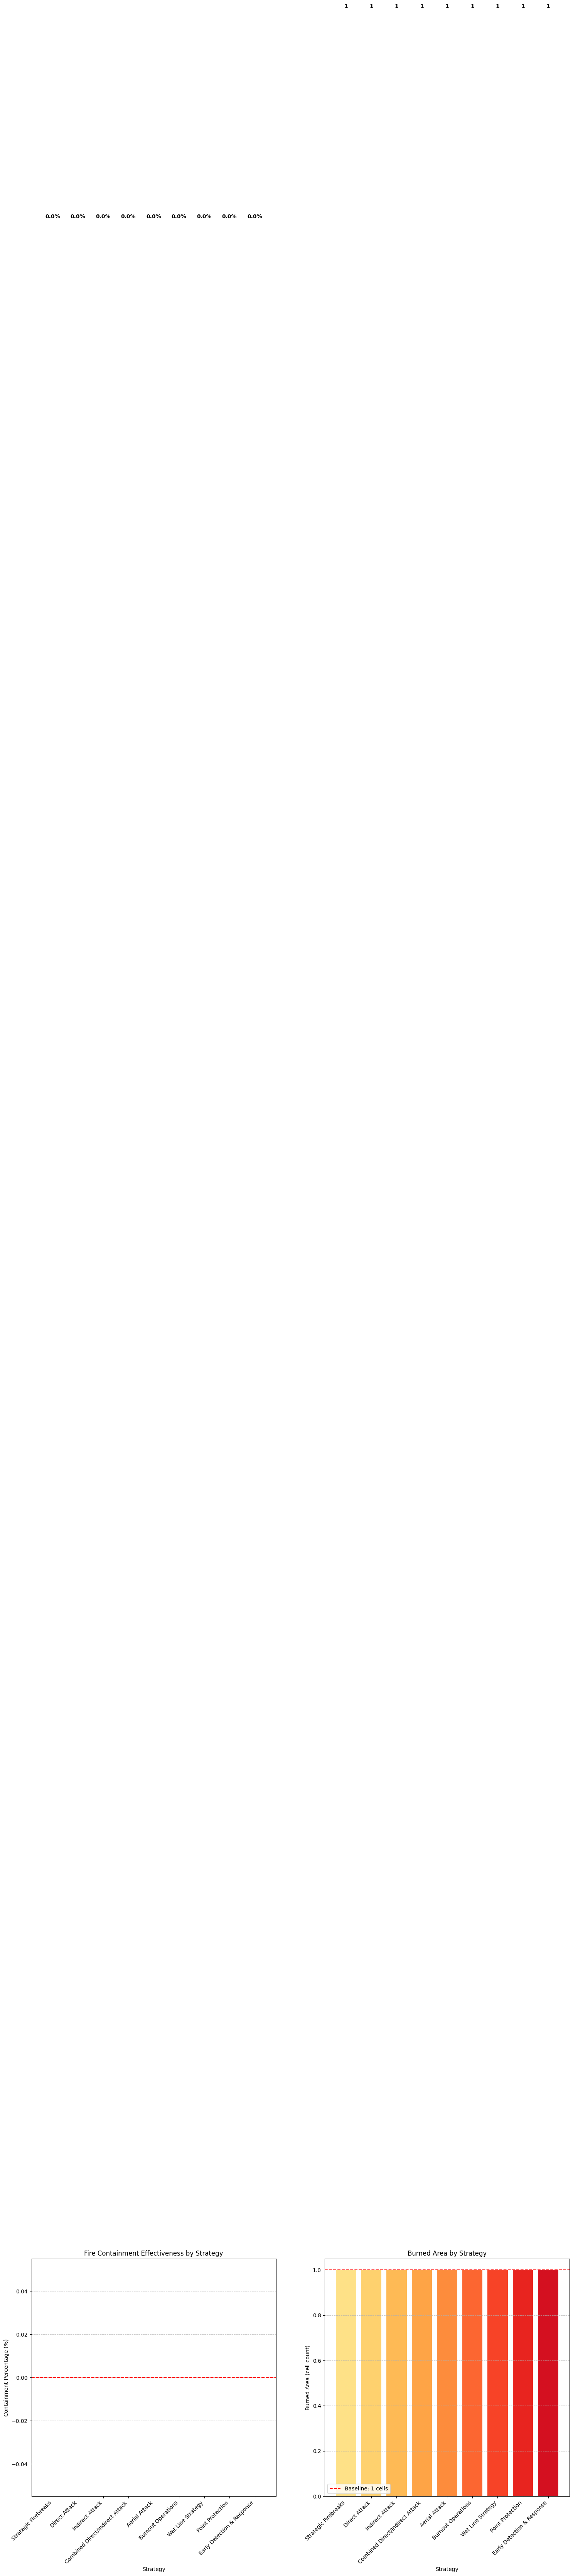

In [12]:
# Extract strategy names and containment percentages
strategies = []
containment_pcts = []
burned_areas = []

for strategy_id, metrics in results.items():
    if strategy_id != 'no_intervention':
        strategies.append(metrics['name'])
        containment_pcts.append(metrics.get('containment_pct', 0))
        burned_areas.append(metrics['burned_area'])

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot containment percentages
containment_colors = plt.cm.YlOrRd(np.linspace(0.8, 0.2, len(strategies)))
ax1.bar(strategies, containment_pcts, color=containment_colors)
ax1.set_title('Fire Containment Effectiveness by Strategy')
ax1.set_ylabel('Containment Percentage (%)')
ax1.set_xlabel('Strategy')
ax1.set_xticklabels(strategies, rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add baseline reference line
ax1.axhline(y=0, color='r', linestyle='--', label='Baseline (No Intervention)')

# Add labels on bars
for i, v in enumerate(containment_pcts):
    ax1.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

# Plot burned areas
burned_colors = plt.cm.YlOrRd(np.linspace(0.2, 0.8, len(strategies)))
ax2.bar(strategies, burned_areas, color=burned_colors)
ax2.set_title('Burned Area by Strategy')
ax2.set_ylabel('Burned Area (cell count)')
ax2.set_xlabel('Strategy')
ax2.set_xticklabels(strategies, rotation=45, ha='right')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add baseline reference line
baseline_area = baseline_result['burned_area']
ax2.axhline(y=baseline_area, color='r', linestyle='--', label=f'Baseline: {baseline_area} cells')
ax2.legend()

# Add labels on bars
for i, v in enumerate(burned_areas):
    ax2.text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


